<a href="https://colab.research.google.com/github/sylpx/Tugas-Kecerdasan-Buatan-4/blob/main/AgnielLorensyusMalino_202355202007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/KecerdasanBuatan/Tugas4/train.tsv', sep='\t')

In [4]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.000,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.000,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.000,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.000,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.000,0,Complete with certificate of authenticity


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [6]:
df.price.describe()

,price
count,1482535.000
mean,26.738
std,38.586
min,0.000
25%,10.000
50%,17.000
75%,29.000
max,2009.000


<ipython-input-7-d37a23ca675b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'], fit = norm);



 mu = 26.75 and sigma = 38.59



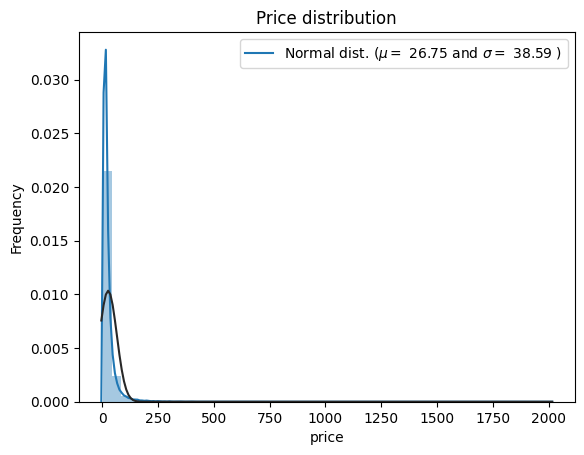

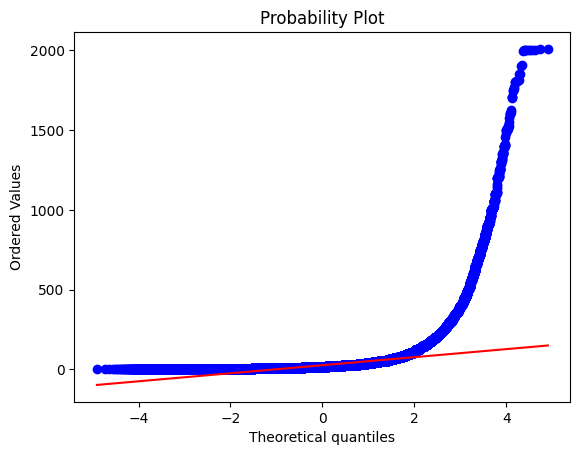

In [7]:
df = df.loc[df['price'] > 0]

sns.distplot(df['price'], fit = norm);
(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)
plt.show();

<ipython-input-8-1e6218baffa6>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log1p(df['price']), fit = norm);



 mu = 2.98 and sigma = 0.75



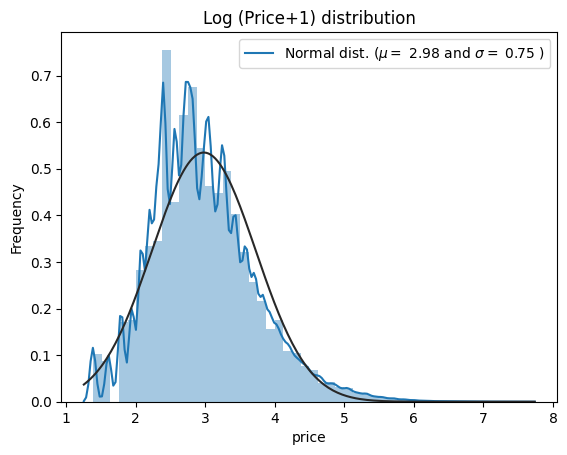

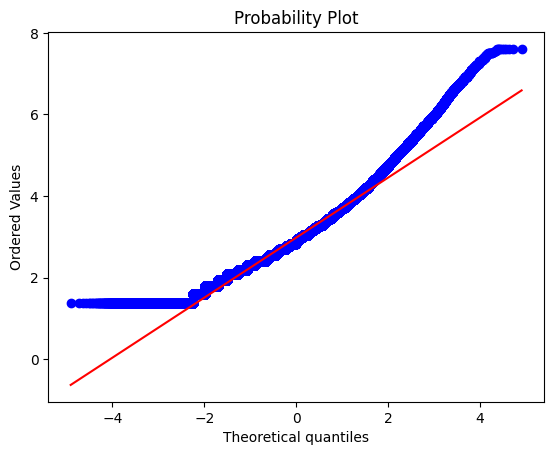

In [8]:
sns.distplot(np.log1p(df['price']), fit = norm);
(mu, sigma) = norm.fit(np.log1p(df['price']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Log (Price+1) distribution')

fig = plt.figure()
res = stats.probplot(np.log1p(df['price']), plot=plt)
plt.show();

In [9]:
df["price"] = np.log1p(df["price"])

In [10]:
df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,6314
brand_name,632336
price,0
shipping,0
item_description,6


We will replace all NaN values in these 3 columns with "missing". There are 82,427 descriptions are "No description yet". So we will replace them by "missing" too.

In [11]:
NUM_BRANDS = 2500
NAME_MIN_DF = 10
MAX_FEAT_DESCP = 50000

df["category_name"] = df["category_name"].fillna("Other").astype("category")
df["brand_name"] = df["brand_name"].fillna("unknown")

pop_brands = df["brand_name"].value_counts().index[:NUM_BRANDS]
df.loc[~df["brand_name"].isin(pop_brands), "brand_name"] = "Other"

df["item_description"] = df["item_description"].fillna("None")
df["item_condition_id"] = df["item_condition_id"].astype("category")
df["brand_name"] = df["brand_name"].astype("category")

In [12]:
df.dtypes

,0
train_id,int64
name,object
item_condition_id,category
category_name,category
brand_name,category
price,float64
shipping,int64
item_description,object


In [13]:
target = df.price.values
features = df[['name', 'item_condition_id', 'category_name', 'brand_name', 'shipping', 'item_description']].copy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=0)

In [15]:
features.dtypes

,0
name,object
item_condition_id,category
category_name,category
brand_name,category
shipping,int64
item_description,object


In [16]:
preprocess = ColumnTransformer(
    [('item_condition_category', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['item_condition_id']),
     ('brand_name_category', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['brand_name']),
     ('category_name_countvec', CountVectorizer(), 'category_name'),
     ('name_countvec', CountVectorizer(min_df=NAME_MIN_DF), 'name'),
     ('description_tfidf', TfidfVectorizer(max_features = MAX_FEAT_DESCP, stop_words = 'english', ngram_range=(1,3)), 'item_description')],
    remainder='passthrough')

In [17]:
model = make_pipeline(
    preprocess,
    Ridge(solver = "lsqr", fit_intercept=False))

In [18]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('item_condition_category',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['item_condition_id']),
                                                 ('brand_name_category',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['brand_name']),
                                                 ('category_name_countvec',
                                                  CountVectorizer(),
                                                  'category_name'),
                                                 ('name_countvec',
                                                  CountVectorizer(min_df=10),
                                                  'name'),
                                                 ('description_tfidf',
                                                  TfidfVectorizer(max_features=50000,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  stop_words='english'),
                                                  'item_description')])),
                ('ridge', Ridge(fit_intercept=False, solver='lsqr'))])

In [19]:
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train RMSE: 0.4425
Test RMSE: 0.4644
